In [70]:
import cv2 as cv
from matplotlib import pyplot as plt
import os
import copy
import scipy.signal
import numpy as np
import imutils

In [26]:
#Global var
input_dir = "../dummy_input"

In [27]:
#Classes
class Board:
    cap = None
    boxes = {}
    directory = "output/board"
    k = 7
    # translation = {"A": "H", "H": "A", "B": "G", "G": "B", "C": "F", "F": "C", "D": "E", "E": "D"}

    def __init__(self, cam=0, bypass=None):
        print("---\n")
        # self.cap = cv.VideoCapture(cam)
        # self.cap.set(3, 1920)
        # self.cap.set(4, 1080)
        if not os.path.isdir(self.directory):
            os.makedirs(self.directory)
        self.boxes = self.calibrate(bypass)
        print("\n---")
        return
    
    def sortChessBoardCorners(self, corners):
        k = self.k
        sorted_points = []

        #Find point furthest from origin
        top = -1
        pos = -1
        for index, point in enumerate(corners):
            x,y = point[0]
            if(x**2+y**2>top):
                top = x**2+y**2
                pos = index
        furthest = corners[pos]

        corners = corners.squeeze()
        #Update coordinate system
        corners = furthest - corners 

        #Sort by x
        temp = np.array(sorted(corners, key=lambda tup: tup[0]))

        for col in range(k):
            s = temp[col*k:col*k+k]
            sorted_points.extend(sorted(s, key=lambda tup: tup[1]))
        sorted_points = np.array(sorted_points)

        #Revert coordinate system
        sorted_points = furthest - sorted_points
        return sorted_points

    def extrapolateColoumn(self, sorted_points):
        k = self.k
        sorted_points = list(sorted_points)
        sorted_points_copy = []
        for col in range(k):
            column = sorted_points[col * k:(col + 1) * k]

            p1 = column[0]
            p2 = column[1]

            p3 = column[-1]
            p4 = column[-2]

            distances = (p1[0] - p2[0], abs(p1[1] - p2[1]))
            new_p1 = [p1[0] + distances[0], p1[1] + distances[1]]
            column.insert(0, new_p1)

            distances = (p3[0] - p4[0], abs(p3[1] - p4[1]))
            new_p1 = [p3[0] + distances[0], p3[1] - distances[1]]
            column.append(new_p1)

            sorted_points_copy.extend(column)

        # Visualizing
        temp = cv.imread(self.directory+"/cap.jpg")
        temp = cv.cvtColor(temp, cv.COLOR_BGR2RGB)
        for corner in sorted_points_copy:
            coord = (int(corner[0]), int(corner[1]))
            cv.circle(temp, center=coord, radius=5, color=(0, 255, 0), thickness=5)
        plt.imsave(self.directory+"/extrapolated_coloumn.jpg", temp)

        print("coloumn extrapolated")
        return sorted_points_copy
    
    def extrapolateRow(self, sorted_points):
        newPoints = []
        column1 = sorted_points[0:9]
        column2 = sorted_points[9:18]

        column3 = sorted_points[45:54]
        column4 = sorted_points[54:63]

        column_first = []
        column_last = []

        for i in range(9):
            p1 = column1[i]
            p2 = column2[i]

            p3 = column3[i]
            p4 = column4[i]

            distances = (abs(p1[0] - p2[0]), p1[1] - p2[1])
            new_p1 = [p1[0] + distances[0], p1[1] + distances[1]]

            newPoints.append(new_p1)
            column_first.append(new_p1)

            distances = (abs(p3[0] - p4[0]), p4[1] - p3[1])
            new_p1 = [p4[0] - distances[0], p4[1] + distances[1]]

            newPoints.append(new_p1)
            column_last.append(new_p1)

        column_first.extend(sorted_points)
        column_first.extend(column_last)

        # Visualizing
        temp = cv.imread(self.directory+"/cap.jpg")
        temp = cv.cvtColor(temp, cv.COLOR_BGR2RGB)
        for corner in column_first:
            coord = (int(corner[0]), int(corner[1]))
            cv.circle(temp, center=coord, radius=5, color=(0, 0, 255), thickness=5)
        plt.imsave(self.directory+"/extrapolated_row.jpg", temp)

        print("row extrapolated")
        return column_first
    
    def getChessboardCorners(self,):
        binary_cvt = BinaryConverter()
        img = binary_cvt.convert(self.directory+"/cap.jpg") * 255
        plt.imsave(self.directory+"/bin.jpg", img)
        ret, corners = cv.findChessboardCorners(img, (7, 7),
                                                flags=cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        
        #Visualizing dotted corners
        temp = cv.imread(self.directory+"/cap.jpg")
        temp = cv.cvtColor(temp, cv.COLOR_BGR2RGB)
        if ret:
            for corner in corners:
                coord = (int(corner[0][0]), int(corner[0][1]))
                cv.circle(temp, center=coord, radius=5, color=(255, 0, 0), thickness=5)
        else:
            raise Exception("No chessboard found")
        plt.imsave(self.directory+"/dotted.jpg", temp)
        print("corners found")
        return corners
    
    def getCornerBoxes(self, points):
        boxes = {}
        c = ord('A') - 1
        for col in range(8):
            c += 1
            for row in range(8):
                boxes[chr(c) + str(row + 1)] = (points[col * 9 + 1 + 9 + row], points[col * 9 + 1 + row],
                                                points[col * 9 + 9 + row], points[col * 9 + row])
        return boxes

    def calibrate(self, bypass=None):
        print("Calibration starting...")
        boxes = {}

        frame = None
        if(bypass==None):
            _, frame = self.cap.read()
        else:
            frame = cv.imread(bypass)
        cv.imwrite(self.directory+"/cap.jpg", frame)

        #Corners points processing
        corners = self.getChessboardCorners()
        sorted_points = self.sortChessBoardCorners(copy.deepcopy(corners))
        points = self.extrapolateColoumn(sorted_points)
        points = self.extrapolateRow(points)
        boxes = self.getCornerBoxes(points) # Getting chessboard corners boxes (coordinate points)

        print("Done. You can check the results at: "+self.directory)
        return boxes
    

class BinaryConverter():
    def topkindex(self, arr, k):
        temp = []
        n = len(arr)
        if(n >= k):
            for i in range(n):
                temp.append((arr[i], i))
            temp = sorted(temp, reverse=True)[:k]
            return [x[1] for x in temp]
        return temp
    
    def convert(self,img_path):
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

        #Get buckets
        bucket = [0 for _ in range(255+1)]

        row, col = img.shape
        for i in range(row):
            for j in range(col):
                bucket[img[i][j]]+=1

        #Get Treshold
        yhat = scipy.signal.savgol_filter(bucket, 100, 3) # Approximating: window size 51, polynomial order 3
        peaks = scipy.signal.find_peaks(yhat)[0] #Returns x values

        #Getting the actual values of the peaks
        peak_y = []
        for p in peaks:
            peak_y.append(yhat[p]) 

        #Getting the bounds for the through
        indices = self.topkindex(peak_y, 2) #Find top 2 peaks
        bounds = [x for index, x in enumerate(peaks) if index in indices]

        lower_bound, upper_bound = min(bounds), max(bounds)

        #Find pixel with the lowest value
        treshold = (lower_bound, yhat[lower_bound])
        for i in range(lower_bound, upper_bound):
            val = yhat[i]
            if val<treshold[1]:
                treshold=(i, val)

        #Apply treshold (Inverted in this case)
        row, col = img.shape
        for i in range(row):
            for j in range(col):
                if img[i][j]<treshold[0]:
                    img[i][j] = 1
                else:
                    img[i][j] = 0
        
        return img

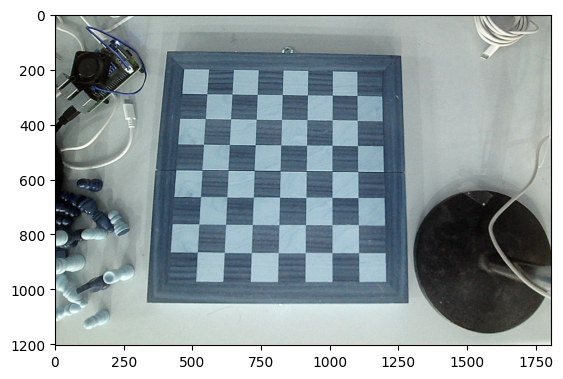

In [28]:
img = cv.imread(input_dir+"/empty1.jpg")
plt.imshow(img)
board = Board(bypass=input_dir+"/empty1.jpg")

(array([911.5266 , 767.22235], dtype=float32), array([1006.51556,  768.5189 ], dtype=float32), array([911.4236 , 867.26794], dtype=float32), array([1008.29675,  868.93695], dtype=float32))


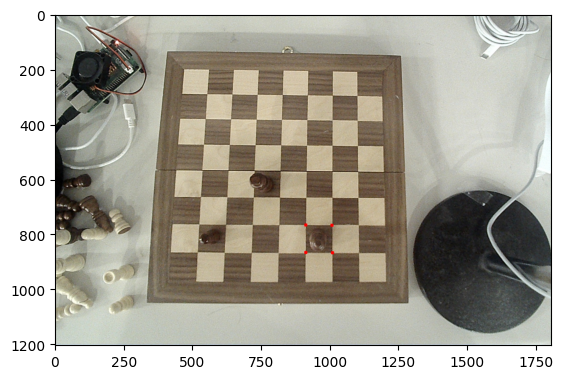

In [44]:
temp = cv.cvtColor(cv.imread(input_dir+"/filled1.jpg"), cv.COLOR_BGR2RGB)
boxes = board.boxes

points = boxes["C2"]
print(points)
for point in points:
    x,y = point
    cv.circle(temp,(int(x),int(y)),1,(255,0,0),10)

plt.imshow(temp)

In [73]:
def resize(imgs, size=100):
    imgs = list(imgs)
    for i in range(len(imgs)):
        img = imgs[i]
        # imgs[i] = cv.resize(img, (size,size))
        imgs[i] = imutils.resize(img,width=size)
    return np.array(imgs)

In [77]:
def crop(img, points):
    top_left, top_right, bottom_right, bottom_left = points
    y_lowerbound = int(min(top_left[1], top_right[1]))
    y_upperbound = int(max(bottom_left[1], bottom_right[1]))

    x_upperbound = int(max(top_right[0], bottom_right[0]))
    x_lowerbound = int(min(bottom_left[0], top_left[0]))

    s = max(y_upperbound - y_lowerbound, x_upperbound - x_lowerbound)

    return img[y_lowerbound:y_lowerbound+s, x_lowerbound:x_lowerbound+s]

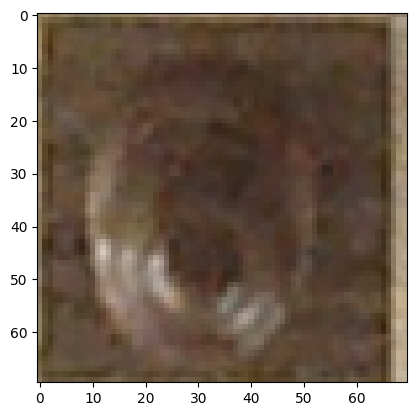

In [78]:
temp = cv.cvtColor(cv.imread(input_dir+"/filled1.jpg"), cv.COLOR_BGR2RGB)
boxes = board.boxes
points = boxes["C2"]

temp = crop(temp, points)
temp = resize([temp], 70)

plt.imshow(temp[0])